In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, Embedding

from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers import Input, Reshape, Dropout
from keras import Model

# from keras.utils import plot_model
from keras.layers import RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

import math
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('datasets/SWaT_Dataset_Normal_v1.csv')
df_anomaly = pd.read_excel('datasets/SWaT_Dataset_Attack_v0.xlsx')

### Preprocessing

In [4]:
df1 = df.drop(columns=[' Timestamp', 'Normal/Attack'])
df1_anomaly = df_anomaly.drop(columns=[' Timestamp', 'Normal/Attack'])

In [5]:
# Rename columns
def get_rename_df(df):
    new_cols = {}
    cols = df.columns
    for i in range(len(cols)):
        new_cols[cols[i]] = cols[i].strip()
    df.rename(columns=new_cols, inplace=True)
    return df

In [6]:
def get_category(df, cols):
    to_one_hot = []
    to_scaled = []
    to_label = []
    for i in cols:
        if i == 'Timestamp' or i == 'Normal/Attack':
            continue
            
        values = df[i].unique()
        if len(values)>3:
            to_scaled.append(i)
        elif len(values) == 3:
            to_one_hot.append(i)
        else:
            to_label.append(i)
            
    return to_one_hot, to_scaled, to_label

In [7]:
def get_scaled(df, cols):
    sc = StandardScaler()
    x_scaled = sc.fit_transform(df[cols])
    df[cols] = x_scaled
    return df

In [8]:
def preprocessing(df):
    df = get_rename_df(df)
    
    to_one_hot, to_scaled, to_label = get_category(df, df.columns)
    
    # Скалируем числовые данные     
    df = get_scaled(df, to_scaled)
    # One_hot для категориальных данных, где значений больше двух
    df = pd.get_dummies(df, columns=to_one_hot, drop_first=True)
    
    return df

In [9]:
df1 = preprocessing(df1)
df1_anomaly = preprocessing(df1_anomaly)

### Окно

In [50]:
def create_x(arr, n_features=3):
    x, y = [], []
    for i in range(len(arr)-n_features-1):
        a = arr[i:(i+n_features)]
        x.append(a)
        y.append(arr[i + n_features])
    return np.array(x), np.array(y)

In [ ]:
n_features=200
X, y = create_x(y, n_features)

In [10]:
window_size=12

X_window=df1.values[np.arange(window_size)[None, :] + np.arange(df1.shape[0]-window_size)[:, None]]
X_window.shape

(494988, 12, 57)

In [11]:
X_an_window=df1_anomaly.values[np.arange(window_size)[None, :] + np.arange(df1_anomaly.shape[0]-window_size)[:, None]]
X_an_window.shape

(449907, 12, 57)

### Инициализация модели

In [12]:
def init_model(timesteps, n_features, num_cells=64, dropout_rate=0.1, lr=0.01):
    lstm_autoencoder = Sequential()
    # Encoder
    lstm_autoencoder.add(LSTM(128, activation='tanh', input_shape=(timesteps, n_features), return_sequences=True))
    lstm_autoencoder.add(LSTM(16, activation='tanh', return_sequences=False))
    lstm_autoencoder.add(RepeatVector(timesteps))
    # Decoder
    lstm_autoencoder.add(LSTM(16, activation='tanh', return_sequences=True))
    lstm_autoencoder.add(LSTM(128, activation='tanh', return_sequences=True))
    lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

    adam = Adam(lr)
    lstm_autoencoder.compile(loss='mse', optimizer=adam)

    cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                                   save_best_only=True,
                                   verbose=0)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)
    return lstm_autoencoder

def fit_model(x, model, epochs=10, batch_size=1000, validation_split=0.2):
    lstm_autoencoder_history = model.fit(x, x, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=0.2,
                        verbose=1, callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]).history
    return lstm_autoencoder_history

def plt_epoch_error(history):
    plt.plot(history['loss'], linewidth=2, label='Train')
    plt.plot(history['val_loss'], linewidth=2, label='Valid')
    plt.legend(loc='upper right')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

In [13]:
X_window.shape

(494988, 12, 57)

In [12]:
X_window_train = X_window[85000:285000] # Для обучения нейронки
X_window_val = X_window[285000:] # Для получения MSE, на котором будет учиться OCSVM

In [15]:
timesteps = X_window_train.shape[1]
n_features = X_window_train.shape[2]

In [146]:
model = init_model(timesteps=timesteps, n_features=n_features)

In [147]:
history = fit_model(X_window_train, model)

Epoch 1/10
160/160 [==============================] - 82s 481ms/step - loss: 0.2344 - val_loss: 0.2022
Epoch 2/10
160/160 [==============================] - 78s 487ms/step - loss: 0.1318 - val_loss: 0.1468
Epoch 3/10
160/160 [==============================] - 78s 486ms/step - loss: 0.0743 - val_loss: 0.0604
Epoch 4/10
160/160 [==============================] - 79s 494ms/step - loss: 0.0253 - val_loss: 0.0387
Epoch 5/10
160/160 [==============================] - 77s 484ms/step - loss: 0.0104 - val_loss: 0.0308
Epoch 6/10
160/160 [==============================] - 77s 484ms/step - loss: 0.0063 - val_loss: 0.0279
Epoch 7/10
160/160 [==============================] - 77s 483ms/step - loss: 0.0049 - val_loss: 0.0232
Epoch 8/10
160/160 [==============================] - 77s 484ms/step - loss: 0.0044 - val_loss: 0.0215
Epoch 9/10
160/160 [==============================] - 78s 489ms/step - loss: 0.0040 - val_loss: 0.0203
Epoch 10/10
160/160 [==============================] - 77s 483ms/step - l

In [148]:
model.save('model_with_window_half')

INFO:tensorflow:Assets written to: model_with_window_half\assets


INFO:tensorflow:Assets written to: model_with_window_half\assets


In [13]:
model = keras.models.load_model('model_with_window_half')

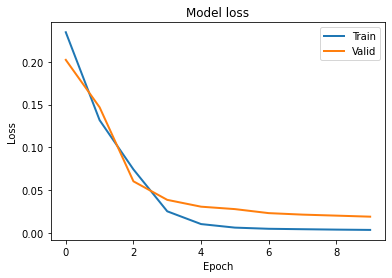

In [149]:
plt_epoch_error(history)

### MSE 

In [14]:
def get_mse(model, X):
    predict = model.predict(X)
    
    X_reshape = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    mse = np.mean(np.power(X_reshape-predict, 2), axis=1)
    
    return mse, predict, X_reshape

def plt_mse(mse, title='MSE'):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.plot(mse)

In [15]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X) 

In [19]:
pred_train = model.predict(X_window_train)

6250/6250 [==============================] - 110s 17ms/step


In [20]:
mse_train = np.mean(np.power(flatten(X_window_train) - flatten(pred_train), 2), axis=1)

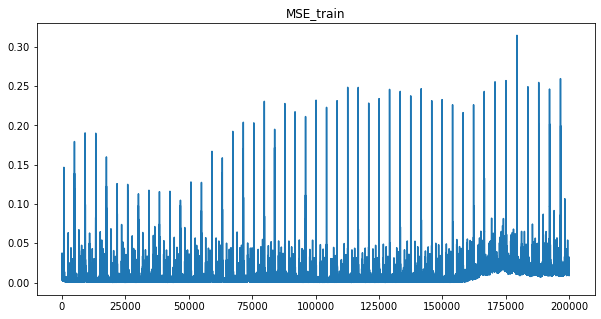

In [21]:
plt_mse(mse_train, title='MSE_train')

6563/6563 [==============================] - 84s 12ms/step


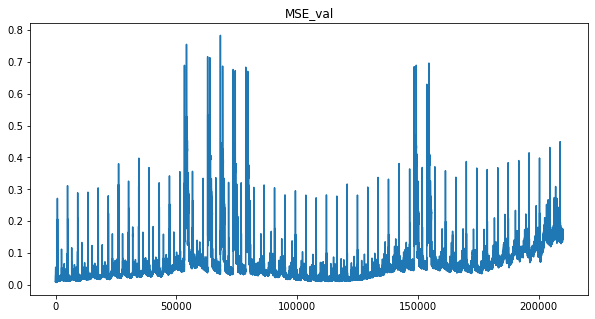

In [16]:
pred_val = model.predict(X_window_val)

mse_val = np.mean(np.power(flatten(X_window_val) - flatten(pred_val), 2), axis=1)

plt_mse(mse_val, title='MSE_val')

In [17]:
pred_test = model.predict(X_an_window)

14060/14060 [==============================] - 205s 15ms/step


In [18]:
mse_test = np.mean(np.power(flatten(X_an_window) - flatten(pred_test), 2), axis=1)

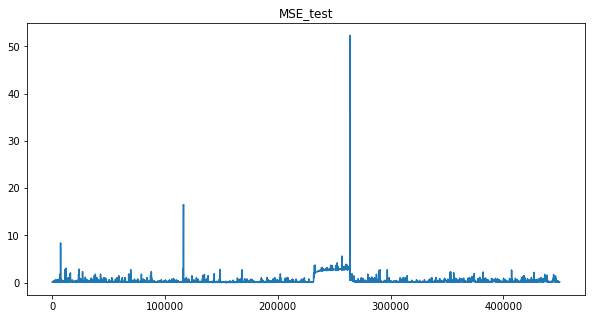

In [19]:
plt_mse(mse_test, title='MSE_test')

#### Возьмем ThreshHold

In [20]:
trh = max(mse_val)

In [21]:
mse_test_list = np.reshape(mse_test, (mse_test.shape[0]))

In [80]:
anomaly_trh = []
for i in mse_test_list:
    if i > trh:
        anomaly_trh.append(1)
    else:
        anomaly_trh.append(0)

In [81]:
labels = {}
for i in anomaly_trh:
    if i in labels.keys():
        labels[i] += 1
    else:
        labels[i] = 1
print(labels)

{0: 413858, 1: 36049}


In [82]:
true_anomaly = []
for i in list(df_anomaly['Normal/Attack'].values):
    if i == 'Normal':
        true_anomaly.append(0)
    else: true_anomaly.append(1)

In [83]:
from sklearn.metrics import classification_report, f1_score
print(classification_report(true_anomaly[:449907], anomaly_trh))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97    395286
           1       0.97      0.64      0.77     54621

    accuracy                           0.95    449907
   macro avg       0.96      0.82      0.87    449907
weighted avg       0.95      0.95      0.95    449907



In [84]:
f1_tr = f1_score(true_anomaly[:449907], anomaly_trh)
f1_tr

0.7687217381713908

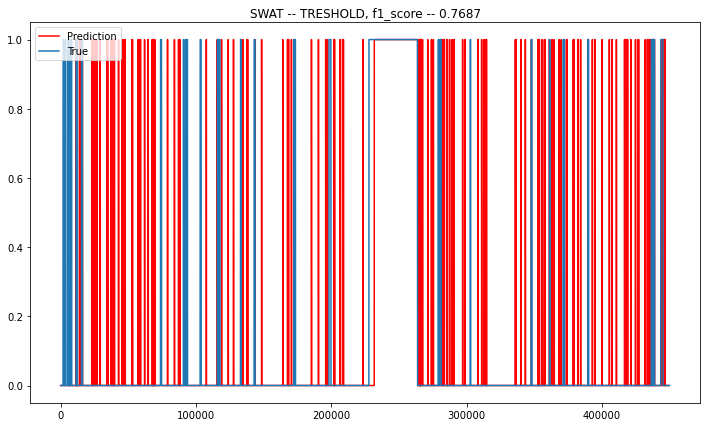

In [109]:
title = 'SWAT -- TRESHOLD, f1_score -- ' +str(round(f1_tr, 4))

plt.figure(figsize=(12,7))
plt.title(title)
plt.plot(anomaly_trh, color='r', label='Prediction')
plt.plot(true_anomaly[:449907], label='True')
plt.legend(loc='upper left')

### OCSVM

In [37]:
import math
from sklearn import svm
from sklearn.metrics import classification_report, f1_score

In [60]:
mse_val_rs = np.reshape(mse_val, (mse_val.shape[0], 1))
mse_test_rs = np.reshape(mse_test, (mse_test.shape[0], 1))

In [39]:
def change_label(label):
    arr = []
    for i in label: 
        if i == -1:
            arr.append(1)
        else:
            arr.append(0)
    return arr

In [40]:
def print_distrib(arr):
    labels = {}
    for i in arr:
        if i in labels.keys():
            labels[i] += 1
        else:
            labels[i] = 1
    print(labels)


#### Подбор гиперпараметров OCSVM

In [31]:
from datetime import datetime
import time

In [331]:
true_anomaly = true_anomaly[:449907]
num = 0
best_f1 = [0,0]
all_models = {}
for i in np.arange(0.001, 0.01, 0.001):                      # Nu
#     for j in ['rbf', 'sigmoid', 'poly']:                  # Kernel
    for k in np.arange(0.0001, 0.01, 0.001):        # Gamma

        start_time = datetime.now()

        print(num, " -- model FIT... -- nu:", i, "| kernel: rbf", '| gamma:', k)
        clf_1 = svm.OneClassSVM(nu=i, kernel='rbf', gamma=k)
        clf_1.fit(mse_val_rs[:100000])
        
        print('Predict...')
        f1_full = 0
        for m in range(10):
            print(m+1, end=' ')
            y_scores = clf_1.predict(mse_test_rs[45000*m:45000*(m+1)])
            anomaly = change_label(y_scores)
            f1 = f1_score(true_anomaly[45000*m:45000*(m+1)], anomaly)
            f1_full+=f1

#       print_distrib(anomaly)
#       f1 = f1_score(true_anomaly[:20000], anomaly)
        f1_avg = f1_full/10

        if f1_avg > best_f1[1]:
            best_f1[0] = num
            best_f1[1] = f1_avg
        all_models[num] = {'nu':i, 'kernel':'rbf', 'gamma':k}
        num+=1

        print('-- F1_average, 10 fold: ', f1_avg)
        print('TIME:', (datetime.now() - start_time).seconds)
        print('------------------------------------')
        

0  -- model FIT... -- nu: 0.001 | kernel: rbf | gamma: 0.0001
Predict...
1 2 3 4 5 6 7 8 9 10 -- F1_average, 10 fold:  0.32214078372289734
TIME: 7
------------------------------------
1  -- model FIT... -- nu: 0.001 | kernel: rbf | gamma: 0.0011
Predict...
1 2 3 4 5 6 7 8 9 10 -- F1_average, 10 fold:  0.27017796357513035
TIME: 7
------------------------------------
2  -- model FIT... -- nu: 0.001 | kernel: rbf | gamma: 0.0021
Predict...
1 2 3 4 5 6 7 8 9 10 -- F1_average, 10 fold:  0.27023850862134874
TIME: 7
------------------------------------
3  -- model FIT... -- nu: 0.001 | kernel: rbf | gamma: 0.0031
Predict...
1 2 3 4 5 6 7 8 9 10 -- F1_average, 10 fold:  0.26782681315205187
TIME: 7
------------------------------------
4  -- model FIT... -- nu: 0.001 | kernel: rbf | gamma: 0.0041
Predict...
1 2 3 4 5 6 7 8 9 10 -- F1_average, 10 fold:  0.26750954473728855
TIME: 7
------------------------------------
5  -- model FIT... -- nu: 0.001 | kernel: rbf | gamma: 0.0051
Predict...
1 2 3 4

Predict...
1 2 3 4 5 6 7 8 9 10 -- F1_average, 10 fold:  0.3218673737343348
TIME: 34
------------------------------------
45  -- model FIT... -- nu: 0.005 | kernel: rbf | gamma: 0.0051
Predict...
1 2 3 4 5 6 7 8 9 10 -- F1_average, 10 fold:  0.32188938194316824
TIME: 34
------------------------------------
46  -- model FIT... -- nu: 0.005 | kernel: rbf | gamma: 0.0061
Predict...
1 2 3 4 5 6 7 8 9 10 -- F1_average, 10 fold:  0.32188938194316824
TIME: 34
------------------------------------
47  -- model FIT... -- nu: 0.005 | kernel: rbf | gamma: 0.0071
Predict...
1 2 3 4 5 6 7 8 9 10 -- F1_average, 10 fold:  0.3218673737343348
TIME: 34
------------------------------------
48  -- model FIT... -- nu: 0.005 | kernel: rbf | gamma: 0.0081
Predict...
1 2 3 4 5 6 7 8 9 10 -- F1_average, 10 fold:  0.3218878835133603
TIME: 34
------------------------------------
49  -- model FIT... -- nu: 0.005 | kernel: rbf | gamma: 0.0091
Predict...
1 2 3 4 5 6 7 8 9 10 -- F1_average, 10 fold:  0.32186318287297

Predict...
1 2 3 4 5 6 7 8 9 10 -- F1_average, 10 fold:  0.3142942897286727
TIME: 62
------------------------------------
89  -- model FIT... -- nu: 0.009000000000000001 | kernel: rbf | gamma: 0.0091
Predict...
1 2 3 4 5 6 7 8 9 10 -- F1_average, 10 fold:  0.3142942897286727
TIME: 62
------------------------------------


In [86]:
clf_1 = svm.OneClassSVM(nu=0.002, kernel="rbf", gamma=0.000009)
print('FIT....')
clf_1.fit(mse_val_rs)
print('FIT DONE')
print('PREDICT...')
y_scores_1 = clf_1.predict(mse_test_rs)
print('PREDICT DONE')

anomaly = change_label(y_scores_1)
print_distrib(anomaly)

print(classification_report(true_anomaly[:449907], anomaly))

FIT....
FIT DONE
PREDICT...
PREDICT DONE
{0: 411722, 1: 38185}
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    395286
           1       0.93      0.65      0.77     54621

    accuracy                           0.95    449907
   macro avg       0.94      0.82      0.87    449907
weighted avg       0.95      0.95      0.95    449907



In [87]:
f1_ocsvm = f1_score(true_anomaly[:449907], anomaly)
f1_ocsvm

0.7687865008727884

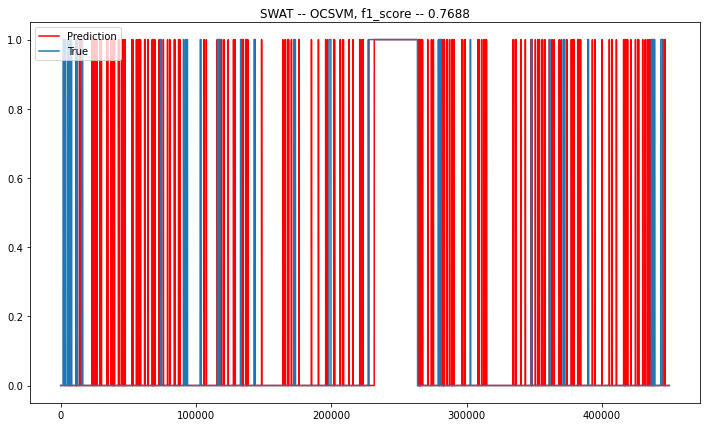

In [110]:
title = 'SWAT -- OCSVM, f1_score -- ' +str(round(f1_ocsvm, 4))

plt.figure(figsize=(12,7))
plt.title(title)
plt.plot(anomaly, color='r', label='Prediction')
plt.plot(true_anomaly[:449907], label='True')
plt.legend(loc='upper left')

#### ROC AUC

In [66]:
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, auc

In [64]:
desicion_func = abs(clf_1.decision_function(mse_test_rs))

In [67]:
print(roc_auc_score(true_anomaly[:449907], desicion_func))

0.7768263307468402


In [68]:
fpr,tpr,thresholds = roc_curve(true_anomaly[:449907], desicion_func)
# desicion_func = clf_1.decision_function(mse_test_rs)
# fpr,tpr,thresholds = roc_curve(true_anomaly[:449907], desicion_func)

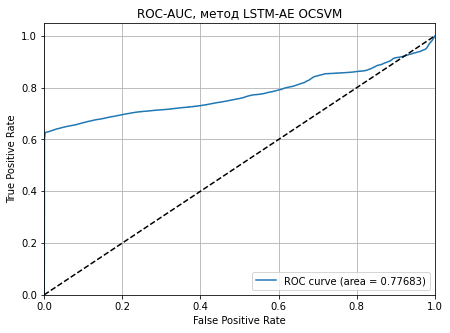

In [69]:
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC, метод LSTM-AE OCSVM')
plt.legend(loc="lower right")
plt.grid()
plt.show()

#### MAE

In [89]:
from metrics import Metrics

In [92]:
time = df_anomaly[' Timestamp'][:449907]

In [93]:
true = true_anomaly[:449907]
pred = anomaly

In [99]:
df_mae = pd.DataFrame(data={'time':np.arange(len(pred)), 'true':true, 'pred':pred}) 

In [100]:
from datetime import datetime

for i in df_mae["time"]:
    df_mae["time"][i] = datetime.fromtimestamp(i).strftime("%Y-%m-%d %I:%M:%S")
    
df_mae['time'] = df_mae['time'].astype('datetime64[ns]')

In [102]:
metrics = Metrics(df_mae['true'], df_mae['pred'], df_mae['time'], 10)

In [103]:
metrics.maerror()

100%|████████████████████████████████████████████████████████████████████████| 449907/449907 [04:24<00:00, 1702.17it/s]

MAE: 0:32:04.864397


datetime.timedelta(seconds=1924, microseconds=864397)

In [104]:
time = df_anomaly[' Timestamp'][:449907][200000:300000]

true = true_anomaly[:449907][200000:300000]
pred = anomaly[200000:300000]

df_mae = pd.DataFrame(data={'time':np.arange(len(pred)), 'true':true, 'pred':pred}) 

from datetime import datetime

for i in df_mae["time"]:
    df_mae["time"][i] = datetime.fromtimestamp(i).strftime("%Y-%m-%d %I:%M:%S")
    
df_mae['time'] = df_mae['time'].astype('datetime64[ns]')

metrics = Metrics(df_mae['true'], df_mae['pred'], df_mae['time'], 10)

metrics.maerror()

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:58<00:00, 1713.44it/s]

MAE: 0:20:28.040933


datetime.timedelta(seconds=1228, microseconds=40933)